In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as th
import torchvision
from torch.utils.data import DataLoader
from torch import nn
from tqdm import tqdm
from matplotlib import pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
from sklearn.metrics import roc_auc_score, average_precision_score,auc,roc_curve, precision_recall_fscore_support

import resplot

## Set parameters and define helper functions

In [2]:
DEVICE = th.device("cuda:1" if th.cuda.is_available() else "cpu")

args = dict()
args['dim_h'] = 40         # factor controlling size of hidden layers
args['n_channel'] = 1      # number of channels in the input data (MNIST = 1, greyscale)
args['n_z'] = 20           # number of dimensions in latent space. 
args['sigma'] = 0.5        # variance in n_z
args['lr'] = 0.0001        # learning rate for Adam optimizer
args['epochs'] = 401       # how many epochs to run for
args['batch_size'] = 2048   # batch size for SGD
args['save'] = False       # save weights at each epoch of training if True
args['train'] = True       # train networks if True, else load networks from saved weights

args['scheduler'] = True   # use scheduler for learning rate or not
args['inClass'] = 0        # set which is the class of the inliers

args['subspace_reg']=0.1   # weight for subspace regularization, 0 if not applied
args['wae']=0.0           # WAE-GAN discriminator lambda, 0 if not WAE
args['lipschitz']=0        # Lipschitz penalty weight, 0 if not applied
args['advantage']=True     # Advantage penalty 

args['outratio'] = 0.3     # outlier ration in unlabeled dataset
args['seed'] = 2           # seed for randomness

seed = args['seed']
np.random.seed(seed)
th.manual_seed(seed)

zero = th.tensor([0], dtype=th.float).cuda().to(DEVICE)
one = th.tensor([1], dtype=th.float).cuda().to(DEVICE)

#USEFUL FUNCTIONS

# methods to freeze/free parameters for optimization
def free_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = True

def frozen_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = False
        
def min_max_normalization(tensor, min_value, max_value):
    min_tensor = tensor.min()
    tensor = (tensor - min_tensor)
    max_tensor = tensor.max()
    tensor = tensor / max_tensor
    tensor = tensor * (max_value - min_value) + min_value
    return tensor


## Neural Networks for Encoder, Decoders, Discriminator

In [3]:
class WAE_Encoder(nn.Module):
    def __init__(self, args):
        super(WAE_Encoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']
        
        # convolutional filters, work excellent with image data
        self.conv = nn.Sequential(
            nn.Conv2d(self.n_channel, self.dim_h, 4, 2, 1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h, self.dim_h * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h * 2, self.dim_h * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 8),
            nn.ReLU(True),
        )
        
        # final layer is fully connected
        self.fc = nn.Linear(self.dim_h * (2 ** 3), self.n_z)
    def forward(self, x):
        x = self.conv(x)
        x = x.squeeze()
        x = self.fc(x)
        return x

class WAE_Decoder(nn.Module):
    def __init__(self, args):
        super(WAE_Decoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']

        # first layer is fully connected
        self.fc = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 8 * 7 * 7),
            nn.ReLU()
        )

        # deconvolutional filters, essentially the inverse of convolutional filters
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(self.dim_h * 8, self.dim_h * 4, 4),
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 4, self.dim_h * 2, 4),
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 2, 1, 4, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, self.dim_h * 8, 7, 7)
        x = self.deconv(x)
        return x



# define the descriminator
class Discriminator(nn.Module):
    def __init__(self, args):
        super(Discriminator, self).__init__()

        self.dim_h = args['dim_h']
        self.n_z = args['n_z']

        # main body of discriminator, returns [0,1]
        self.main = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.main(x)
        return x

## Prepare dataset

In [4]:
#Download MNIST

img_transform = transforms.Compose([
    transforms.ToTensor(),
])

trainset = datasets.MNIST(root = 'data', train = True, download = True, transform = img_transform)
testset = datasets.MNIST(root = 'data', train = False, download = True, transform = img_transform)


#Get unlabeled dataset from testing
testIN = min_max_normalization(testset.test_data[np.where(testset.test_labels == args['inClass'])].type('torch.FloatTensor'),0.0,1.0)
testOUT = min_max_normalization(testset.test_data[np.where(testset.test_labels != args['inClass'])].type('torch.FloatTensor'),0.0,1.0)

#We want to have the same size of data for all the runs, even when we change the outlier ratio.
#We consider outlier ratio from 0.1 to 0.5. Thus, inlier ratio from 0.9 to 0.5
#Given that usually inlier class is only one and outliers all the rest, with 0.1 outlier ratio and 0.9
#inlier ratio we have the smallest unlabeled dataset, we will use this size for the unlabeled dataset.
maxInlierRatio = 0.9
unlabeledSize = int(testIN.shape[0]*(1.0/maxInlierRatio))

outSize = int(unlabeledSize * args['outratio'])
inSize = int(unlabeledSize * (1-args['outratio']))
#Update unlabeledSize given that the above rounding may change the total
unlabeledSize = outSize + inSize
unlabeledOUT = testOUT[:outSize]
unlabeledIN = testIN[:inSize]

unlabeled = np.concatenate((unlabeledIN,unlabeledOUT))

unlabeled_labels = np.concatenate((np.zeros(inSize),np.ones(outSize)))


#reshape for convolutional and convert
unlabeled = th.FloatTensor(unlabeled.reshape(-1,1,28,28)).cuda().to(DEVICE)

#Shuffle the unlabeled data, otherwise in the training it will see first all the inliers, then the outliers
shuffle_idx = np.arange(unlabeledSize)
np.random.shuffle(shuffle_idx)
unlabeled = unlabeled[shuffle_idx]
unlabeled_labels = unlabeled_labels[shuffle_idx]

#Get positive data from training set
positive = min_max_normalization(trainset.train_data[np.where(trainset.train_labels == args['inClass'])].type('torch.FloatTensor'),0.0,1.0)
#Set positive subset to be equal in size to unlabeled subset
positive = np.array(positive[:unlabeledSize])
#Reshape for convolutional net and convert
positive = th.FloatTensor(positive.reshape(-1,1,28,28)).cuda().to(DEVICE)


positive_loader = DataLoader(
    dataset=positive,
    batch_size=args['batch_size'],
    drop_last=False,
    shuffle=False
)

unlabeled_loader = DataLoader(
    dataset=unlabeled,
    batch_size=args['batch_size'],
    drop_last=False,
    shuffle=False
)

## Initialize models and optimizers

In [5]:
error = nn.MSELoss(reduction='none')
criterion = nn.MSELoss()

encoder = WAE_Encoder(args).cuda().to(DEVICE)
decoderI = WAE_Decoder(args).cuda().to(DEVICE)
decoderO = WAE_Decoder(args).cuda().to(DEVICE)
discriminator = Discriminator(args).cuda().to(DEVICE)

enc_optim = th.optim.Adam(encoder.parameters(), lr = args['lr'])
decI_optim = th.optim.Adam(decoderI.parameters(), lr = args['lr'])
decO_optim = th.optim.Adam(decoderO.parameters(), lr = args['lr'])
dis_optim = th.optim.Adam(discriminator.parameters(), lr = args['lr'])

if args['scheduler']:
    enc_scheduler = th.optim.lr_scheduler.StepLR(enc_optim, step_size=30, gamma=0.5)
    decI_scheduler = th.optim.lr_scheduler.StepLR(decI_optim, step_size=30, gamma=0.5)
    decO_scheduler = th.optim.lr_scheduler.StepLR(decO_optim, step_size=30, gamma=0.5)
    dis_scheduler = th.optim.lr_scheduler.StepLR(dis_optim, step_size=30, gamma=0.5)

## Semi-supervised training 

In [6]:
print("Epoch\tLoss\tAdv\tPrec\tRec\tF1\tAUC")
advantageI = 0.0
for epoch in range(args['epochs']):
    y_pred = []
    for cnt, x in enumerate(zip(positive_loader, unlabeled_loader)):
        #split the dataset int positive p, unlabeled u, both combined x
        p = x[0]
        u = x[1]
        x = th.cat((x[0],x[1]),0)
        
        #zero the gradients
        encoder.zero_grad()
        decoderI.zero_grad()
        decoderO.zero_grad()
        discriminator.zero_grad()
        
        if args['wae'] > 0:
            ###################### TRAIN DISCRIMINATOR ######################

            # freeze auto encoder params
            frozen_params(decoderI)
            frozen_params(decoderO)
            frozen_params(encoder)
            # free discriminator params
            free_params(discriminator)

            # run discriminator against randn draws
            z = (th.randn(x.size()[0], args['n_z']) * args['sigma']).cuda().to(DEVICE)
            d_z = discriminator(z)

            # run discriminator against encoder z's
            z_hat = encoder(x)
            d_z_hat = discriminator(z_hat)

            d_z_loss = args['wae']*th.log(d_z).mean()
            d_z_hat_loss = args['wae']*th.log(1 - d_z_hat).mean()

            # formula for ascending the descriminator -- -one reverses the direction of the gradient.
            d_z_loss.backward(-one)
            d_z_hat_loss.backward(-one)

            dis_optim.step()
        
        
        ###################### TRAIN AUTOENCODER ######################

        # flip which networks are frozen, which are not
        free_params(decoderI)
        free_params(decoderO)
        free_params(encoder)
        frozen_params(discriminator)


        # encode positive and unlabeled
        z_hatP = encoder(p)
        z_hatU = encoder(u)
        
        # decode positive with inlier decoder
        x_hatP = decoderI(z_hatP)
        
        # decode unlabeled with both decoders
        x_hatUO = decoderO(z_hatU)
        x_hatUI = decoderI(z_hatU)
        
        #resplot.plot_rows(unlabeled,args,encoder,decoders = [decoderI,decoderO], seed = seed)
        
        lossI = error(x_hatP,p).mean(axis=(1,2,3))
        lossUI = error(x_hatUI,u).mean(axis=(1,2,3))
        lossUO = error(x_hatUO,u).mean(axis=(1,2,3))
    
        #compute advantage on best reconstructed sample to make training stable.
        if args['advantage']:
            advantageI = lossUO.min() - lossI.min()
        
        # compute y based on the decoder with lower error.
        y = (lossUO<(lossUI+advantageI)).float()
                
        # append this prediction to evaluate when the epoch ends
        
        y_pred.extend(list(y.cpu().numpy()))
        
                
        # compute competitive AE loss
        loss = th.mean(y*lossUO + (1-y)*lossUI) + th.mean(lossI)

        if(args['subspace_reg']>0):
            z_hat2 = th.cat((z_hatP,z_hatU),0).detach()
            ws = th.exp(-th.pdist(x.reshape(x.shape[0],-1)/args['subspace_reg'],2))
            o_len = (int)(x.shape[0]/4)
            ws[-o_len:]=0
            diff = th.pow(th.pdist(z_hat2,1),2)
            loss += args['subspace_reg'] * th.mean(ws*diff)
        
        if(args['wae'])>0: 
            z_hat = encoder(x)
            # discriminate latents        
            d_z_hat = discriminator(z_hat)
            # calculate discriminator loss
            d_loss = args['wae'] * (th.log(d_z_hat)).mean()
            # compute gradient to fool discriminator
            d_loss.backward(-one)
            
        loss.backward(one)
        
        enc_optim.step()
        decI_optim.step()
        decO_optim.step()
        
    
    if epoch % 20 == 0:
        precision, recall, F1, _ = precision_recall_fscore_support(unlabeled_labels,
                                                               y_pred,
                                                               average='binary')
        AUC = roc_auc_score(unlabeled_labels,y_pred)
        
        print("%d\t%1.3f\t%1.3f\t%1.3f\t%1.3f\t%1.3f\t%1.3f" % (epoch,loss.item(),advantageI,precision, recall,F1,AUC))
    
        

Epoch	Loss	Adv	Prec	Rec	F1	AUC
0	0.685	0.002	0.193	0.129	0.154	0.449
20	0.223	-0.008	0.345	0.936	0.504	0.587
40	0.167	-0.000	0.371	0.994	0.540	0.636
60	0.123	-0.002	0.505	0.994	0.670	0.789
80	0.090	-0.001	0.558	0.991	0.714	0.827
100	0.071	0.000	0.567	0.988	0.720	0.832
120	0.058	0.000	0.573	0.988	0.725	0.836
140	0.049	-0.000	0.576	0.988	0.728	0.838
160	0.042	-0.001	0.577	0.988	0.729	0.839
180	0.036	-0.001	0.578	0.988	0.729	0.839
200	0.032	-0.001	0.578	0.988	0.729	0.839
220	0.029	-0.001	0.578	0.988	0.729	0.839
240	0.025	-0.001	0.578	0.988	0.729	0.839
260	0.023	-0.002	0.578	0.988	0.729	0.839
280	0.021	-0.002	0.578	0.988	0.729	0.839
300	0.019	-0.002	0.578	0.988	0.729	0.839
320	0.017	-0.002	0.578	0.988	0.729	0.839
340	0.016	-0.002	0.578	0.988	0.729	0.839
360	0.015	-0.002	0.578	0.988	0.729	0.839
380	0.014	-0.001	0.578	0.988	0.729	0.839
400	0.013	-0.001	0.578	0.988	0.729	0.839


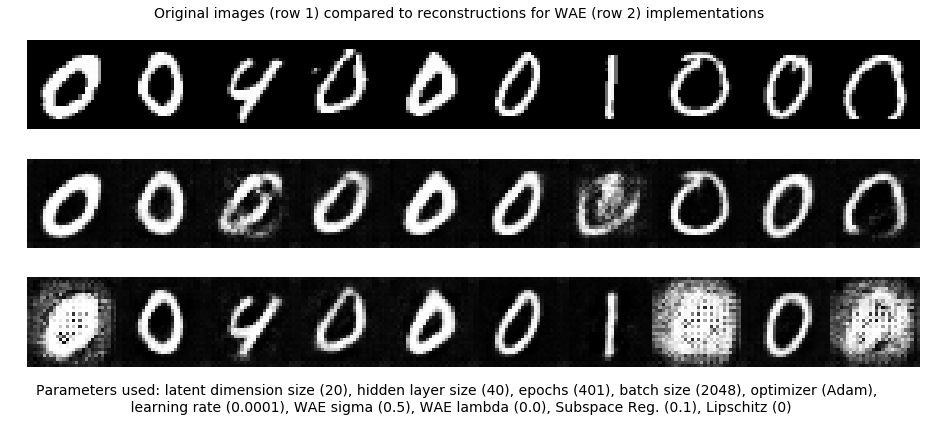

In [7]:
resplot.plot_rows(unlabeled[10:],args,encoder,decoders = [decoderI,decoderO], seed = seed)

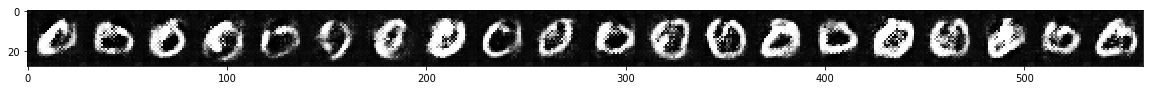

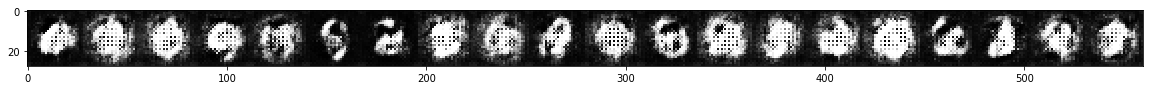

In [8]:
z = (th.randn(20, args['n_z']) * args['sigma']).cuda().to(DEVICE)
generatedI = decoderI(z)
generatedO = decoderO(z)
plt.figure(figsize = (20,2))
plt.imshow(np.stack([generatedI.reshape((-1,28,28)).cpu().detach().numpy()[i].transpose() for i in range(20)]).reshape(-1,28).transpose(), cmap = "gray")
plt.show()
plt.figure(figsize = (20,2))
plt.imshow(np.stack([generatedO.reshape((-1,28,28)).cpu().detach().numpy()[i].transpose() for i in range(20)]).reshape(-1,28).transpose(), cmap = "gray")
plt.show()

In [9]:
loss

tensor(0.0128, device='cuda:1', grad_fn=<AddBackward0>)

In [10]:
th.pdist(z_hat,1)

NameError: name 'z_hat' is not defined